In this small project we want to fit a Linear Regressor to an independent dataset X and the dependent dataset Y. However 
25 percent of the combined data points are outliers with respect to the data in Y and have to be removed.

In [73]:
import numpy as np
import pandas as pd

In [74]:
X_train = np.load('/home/internet/Downloads/X_train.npy')

Y_train = np.load('/home/internet/Downloads/y_train.npy')

In [75]:
print(X_train[:10])
print('The shape of the input is', X_train.shape)

[[ 2.43603602e+02  3.20129329e+02  2.63887099e+02  1.38347154e+02
   1.87518604e+02]
 [ 8.07288058e-01 -3.68178229e-02  6.27205787e+02  1.49999110e+02
   1.09295966e+02]
 [-8.90127732e+01  1.33187018e+00  1.57805750e+02  1.45964094e+02
   1.04658223e+02]
 [-3.00950338e+02 -1.38330765e+01 -8.38057882e+01  1.27188902e+02
   8.97627071e+01]
 [ 3.75153738e+02  1.58006206e+02 -2.72035822e+02  1.11853997e+02
   1.61561648e+02]
 [ 3.09215024e+02 -1.31222983e+00  4.55564317e+01  1.54260779e+02
   1.22786378e+02]
 [ 2.35650507e+02  1.43327670e+02  3.05527650e+02  1.51224951e+02
   1.52645096e+02]
 [ 2.76023088e+02  8.31841400e+01  4.08366035e+02  1.46509192e+02
   1.40265753e+02]
 [-5.72847737e+01  1.81502721e+02  1.05741432e+02  1.30288413e+02
   1.46058148e+02]
 [-1.37409955e+02  2.10888735e+02  1.62544129e+02  1.55424654e+02
   1.47178789e+02]]
The shape of the input is (200, 5)


In [76]:
print(Y_train[:10])
print('The shape of the output is', Y_train.shape)

[-2.73738353 -0.41096878 14.83353307  3.96080398 10.40039261 -0.83868445
 -1.73503068 -1.81166761 -0.19170165 -0.08824088]
The shape of the output is (200,)


For the detection and removal of outliers there are multiple methods. We are going to use isolation forests and the third quartile.

In [77]:
df = pd.DataFrame(X_train, columns=['X1','X2','X3','X4','X5'])
df['Y'] = Y_train

In [78]:
df.loc[:5]

,X1,X2,X3,X4,X5,Y
0,243.603602,320.129329,263.887099,138.347154,187.518604,-2.737384
1,0.807288,-0.036818,627.205787,149.999110,109.295966,-0.410969
2,-89.012773,1.331870,157.805750,145.964094,104.658223,14.833533
3,-300.950338,-13.833076,-83.805788,127.188902,89.762707,3.960804
4,375.153738,158.006206,-272.035822,111.853997,161.561648,10.400393
5,309.215024,-1.312230,45.556432,154.260779,122.786378,-0.838684


In [79]:
third_quartile = np.percentile(df['Y'], 75)
outliers_quart = df[ df['Y'] >= third_quartile]
inliers_quart = df[ df['Y'] < third_quartile]

Now we will compute the outliers with an isolation forest and compare the two results to decide which one we will
eventually choose for the training of our model.

In [80]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(contamination=0.25, random_state=0).fit(df[['Y']])
df['results'] = clf.predict(df[['Y']]) #returns -1 for outliers and 1 for inliers
outliers_iso = df[ df['results'] == -1]
inliers_iso = df[ df['results'] == 1]

In [81]:
len(outliers_quart['Y'])

50

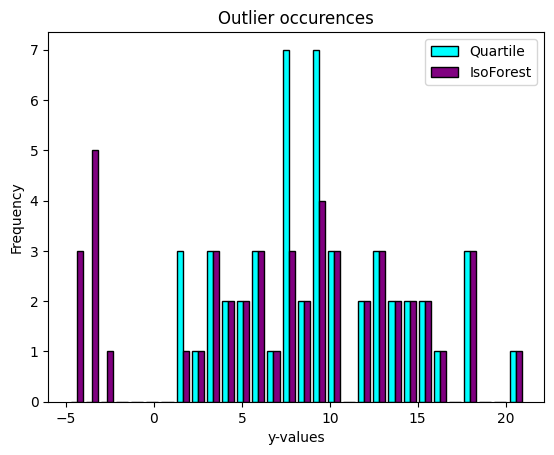

In [82]:
import matplotlib.pyplot as plt
plt.hist([outliers_quart['Y'].to_numpy(), outliers_iso['Y'].to_numpy()], bins=30, color=['cyan', 'Purple'], edgecolor='black')
 
plt.xlabel('y-values')
plt.ylabel('Frequency')
plt.title('Outlier occurences')
 
plt.legend(['Quartile', 'IsoForest'])
 
plt.show()

It seems like the quartile method returns outliers that are not as much spread apart. The values tend to bunch up somewhere around 10. To make this observation more precise, we are going to calculate the mean and the variance of the cleaned dateset.


In [83]:
from tabulate import tabulate
mydata = [
    ["mean", str(np.mean(inliers_iso['Y'])), str(np.mean(inliers_quart['Y']))], 
    ["variance", str(np.var(inliers_iso['Y'])), str(np.var(inliers_quart['Y']))], 
]
 
# create header
head = ["","Iso", "Quart"]
 
# display table
print(tabulate(mydata, headers=head, tablefmt="grid"))

+----------+-----------+----------+
|          |       Iso |    Quart |
+==========+===========+==========+
| mean     | -0.226596 | -0.866   |
+----------+-----------+----------+
| variance |  4.99043  |  1.67708 |
+----------+-----------+----------+


As the variance of the data obtained by applying the quartile method is lower, we are going to opt for this data set. Our assumpution is that this will help to train the model. We will now proceed to use the Lasso regularization for training. This helps to discard the features that are less important by setting their coefficients to zero. As a hyperparameter we go for alpha = 0.01 since this is a common choice.

In [84]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=0.1)
clf.fit(inliers_quart[['X1','X2','X3','X4','X5']].loc[:150], inliers_quart[['Y']].loc[:150])
print(clf.coef_)
print(clf.intercept_)

[-0.00483085 -0.00559287 -0.0018288  -0.         -0.        ]
[0.74130235]


In [85]:
# run a test to evaluate the performance:
from sklearn.metrics import mean_squared_error
y_pred = clf.predict(inliers_quart[['X1','X2','X3','X4','X5']].loc[150:])
print(mean_squared_error(inliers_quart[['Y']].loc[150:], y_pred))

0.012965923903467135
